In [1]:
import pandas as pd
import numpy as np

import os
import itertools
from collections import Counter
from wordcloud import WordCloud
import re
import string

from transformers import pipeline
import torch
torch.cuda.is_available()
from transformers import AutoTokenizer


import matplotlib.pyplot as plt

import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer 

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from  sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
cust_reviews = pd.read_csv('data/cleaned_reviews.csv')
cust_reviews.head()

,Unnamed: 0,reviews,cleaned,tokens
0,0,Old A320 with narrow pitch. Flight perfectly o...,old a320 with narrow pitch. flight perfectly o...,"['old', 'a320', 'narrow', 'pitch', 'perfectly'..."
1,1,Another BA Shambles. Started off well with exc...,another ba shambles. started off well with exc...,"['another', 'shambles', 'started', 'well', 'ex..."
2,2,BA cancelled my flight home to Heathrow on Dec...,ba cancelled my flight home to heathrow on dec...,"['cancelled', 'home', 'heathrow', 'dec', '19th..."
3,3,"BA cancelled my flight home, the last flight o...","ba cancelled my flight home, the last flight o...","['cancelled', 'home', 'last', 'day', 'heathrow..."
4,4,"Turned up 3.5 hours in advance, Terminal 5 at ...","turned up 3.5 hours in advance, terminalat lon...","['turned', '3.5', 'hours', 'advance', 'termina..."


In [3]:
def regex_clean(txt, regex):
    """Replace any text matching the regex

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove matches
    regex : string 
        A text string of the regex pattern you want to match

    Returns
    -------
    The same txt string with the matches removes
    """

    return " ".join(re.sub(regex, " ", txt).split())

### Labelling Sentiments

In [4]:
cust_reviews.head()

,Unnamed: 0,reviews,cleaned,tokens
0,0,Old A320 with narrow pitch. Flight perfectly o...,old a320 with narrow pitch. flight perfectly o...,"['old', 'a320', 'narrow', 'pitch', 'perfectly'..."
1,1,Another BA Shambles. Started off well with exc...,another ba shambles. started off well with exc...,"['another', 'shambles', 'started', 'well', 'ex..."
2,2,BA cancelled my flight home to Heathrow on Dec...,ba cancelled my flight home to heathrow on dec...,"['cancelled', 'home', 'heathrow', 'dec', '19th..."
3,3,"BA cancelled my flight home, the last flight o...","ba cancelled my flight home, the last flight o...","['cancelled', 'home', 'last', 'day', 'heathrow..."
4,4,"Turned up 3.5 hours in advance, Terminal 5 at ...","turned up 3.5 hours in advance, terminalat lon...","['turned', '3.5', 'hours', 'advance', 'termina..."


In [5]:
cols_to_remove=['Unnamed: 0','cleaned']
cust_reviews.drop(cols_to_remove, axis=1, inplace=True)
cust_reviews.head()




,reviews,tokens
0,Old A320 with narrow pitch. Flight perfectly o...,"['old', 'a320', 'narrow', 'pitch', 'perfectly'..."
1,Another BA Shambles. Started off well with exc...,"['another', 'shambles', 'started', 'well', 'ex..."
2,BA cancelled my flight home to Heathrow on Dec...,"['cancelled', 'home', 'heathrow', 'dec', '19th..."
3,"BA cancelled my flight home, the last flight o...","['cancelled', 'home', 'last', 'day', 'heathrow..."
4,"Turned up 3.5 hours in advance, Terminal 5 at ...","['turned', '3.5', 'hours', 'advance', 'termina..."


In [6]:
# train=cust_reviews.sample(frac=0.7,random_state=200)
# test=cust_reviews.drop(train.index)


# print(train.shape)
# print(test.shape)

In [7]:
sentiment_pipeline = pipeline("sentiment-analysis")

def label_sentiment(txt):

    return sentiment_pipeline(txt[:500])[0]['label'] 


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [8]:

cust_reviews['sentiment'] = cust_reviews['reviews'].apply(label_sentiment)
cust_reviews.head()


,reviews,tokens,sentiment
0,Old A320 with narrow pitch. Flight perfectly o...,"['old', 'a320', 'narrow', 'pitch', 'perfectly'...",POSITIVE
1,Another BA Shambles. Started off well with exc...,"['another', 'shambles', 'started', 'well', 'ex...",POSITIVE
2,BA cancelled my flight home to Heathrow on Dec...,"['cancelled', 'home', 'heathrow', 'dec', '19th...",NEGATIVE
3,"BA cancelled my flight home, the last flight o...","['cancelled', 'home', 'last', 'day', 'heathrow...",NEGATIVE
4,"Turned up 3.5 hours in advance, Terminal 5 at ...","['turned', '3.5', 'hours', 'advance', 'termina...",NEGATIVE


### Peecentage of sentiments

In [28]:
cust_reviews['sentiment'].value_counts(normalize=True)

NEGATIVE    0.744
POSITIVE    0.256
Name: sentiment, dtype: float64

### EDA

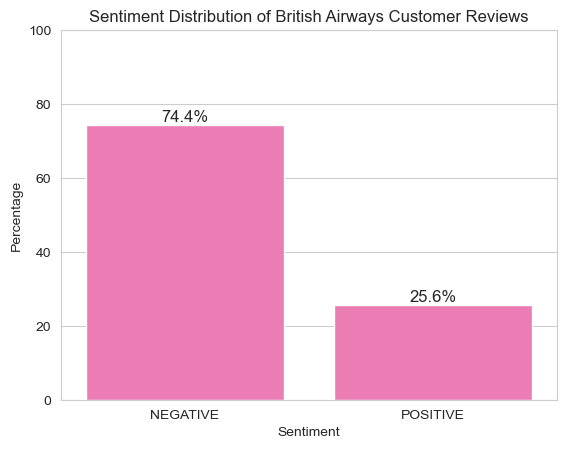

In [48]:
import seaborn as sns

# Calculate percentage of each sentiment value
sentiment_counts = cust_reviews['sentiment'].value_counts(normalize=True) * 100

# Plot sentiment counts in a bar plot with labels showing percentage
sns.set_style('whitegrid')
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, color='hotpink')
plt.title('Sentiment Distribution of British Airways Customer Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.ylim(0, 100)
for i, val in enumerate(sentiment_counts.values):
    plt.text(i, val, f'{val:.1f}%', horizontalalignment='center', verticalalignment='bottom', fontdict={'fontsize': 12})
plt.show()

## Data Pre-processing

In [30]:
## Creating a stemmer object and a list of stopwords to remove

lemma = WordNetLemmatizer()
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(string.punctuation)
stpwrd.extend(['well','really','also','asked','airline','better','would','could','have','any'])

## Utilising the above techniques, we define a more complex function to prepare our data for analysis


def prep_data(review):
    """ Cleans up a review!

    Parameters
    ----------
    review : string
        A text string that you want to parse and remove matches

    Returns
    -------
    Cleaned up string - tokenized & stemmed!
    """   
    
    ## Pre Token Cleaning - Stuff that applies to a string.
    
    review = review.lower() 
    review = regex_clean(review, r'\s\d+\s')

    review = re.sub(r'\d+', '', review)

    ## Go-Go-Token-Rangers
    review = word_tokenize(review)

    ## Post Token Cleaning - Stuff that applies to a list 
        
    review = [lemma.lemmatize(word) for word in review]
    review = [word for word in review if word not in stpwrd and len(word)>3]
    
    return review

Creating Documents

In [31]:
def get_idf_weights(df):
    docs = [" ".join(prep_data(x)) for x in df['reviews']]
    cv=CountVectorizer(ngram_range=(1,2),stop_words=stpwrd,min_df=.1) 
    # this steps generates word counts for the words in your docs 
    word_count_vector=cv.fit_transform(docs)
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
    tfidf_transformer.fit(word_count_vector)
    # print idf values 
    df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(),columns=["idf_weights"]) 
    # sort ascending 

    df_idf.sort_values(by=['idf_weights'],ascending=False)

    return df_idf

In [32]:
docs = [" ".join(prep_data(x)) for x in cust_reviews['reviews']]


In [33]:
# create a vocabulary of words, 
# ignore words that appear in 85% of documents, 
# eliminate stop wordsa

cv=CountVectorizer(ngram_range=(1,2),stop_words=stpwrd,min_df=.1) 
# this steps generates word counts for the words in your docs 
word_count_vector=cv.fit_transform(docs)

In [34]:
word_count_vector.shape


(2000, 94)

In [35]:
features = word_count_vector.toarray()

In [36]:
features.shape

(2000, 94)

In [37]:
vocab = list(cv.get_feature_names_out())


In [38]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [39]:
	
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(),columns=["idf_weights"]) 
# sort ascending 

df_idf.sort_values(by=['idf_weights'],ascending=False)

,idf_weights
short,3.298097
gate,3.288196
haul,3.283282
available,3.273526
extra,3.273526
...,...
time,1.827178
seat,1.672865
service,1.664088
london,1.429746


### Fit a sentiment classifying model to the data

In [40]:
# create dataframe
X = pd.DataFrame(features,columns=vocab)

y = cust_reviews['sentiment'].values
X.head()

,aircraft,airport,airway,another,arrived,available,back,board,boarding,booked,...,staff,still,take,ticket,time,told,took,trip,world,year
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,2,0,0,0,0,0
3,0,0,0,2,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# test train split
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2)

In [42]:
## We create our model
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [43]:
X_train['y_pred'] = lr.predict(X_train)
X_test['y_pred'] = lr.predict(X_test)

In [44]:
def apr(y_pred, y_real):
    """
    Funtcion to calculate accuracy,precision,recall and f1-score 
    """
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1

In [45]:
print(apr(y_train, X_train['y_pred']))

ValueError: pos_label=1 is not a valid label. It should be one of ['NEGATIVE', 'POSITIVE']

In [ ]:
print(apr(y_test, X_test['y_pred']))

Accuracy:0.79
Precision:0.5
Recall:0.6666666666666666
F1:0.5714285714285715
(0.79, 0.5, 0.6666666666666666, 0.5714285714285715)


In [ ]:
# from nltk.sentiment.vader import SentimentIntensityAnalyzer

# df = cust_reviews['reviews']

# # Extract the text column
# text = cust_reviews['reviews']

# # Initialize the sentiment analyzer
# sid = SentimentIntensityAnalyzer()

# # Compute the sentiment scores for each review
# scores = []
# for review in text:
#     scores.append(sid.polarity_scores(review))

# # Add the sentiment scores to the DataFrame
# df["neg"] = [score["neg"] for score in scores]
# df["neu"] = [score["neu"] for score in scores]
# df["pos"] = [score["pos"] for score in scores]
# df["compound"] = [score["compound"] for score in scores]

# # Compute the overall sentiment of the reviews
# df["overall_sentiment"] = "neutral"
# df.loc[df["compound"] > 0.5, "overall_sentiment"] = "positive"
# df.loc[df["compound"] < -0.5, "overall_sentiment"] = "negative"

# # Print the proportion of positive, negative, and neutral reviews
# print(df["overall_sentiment"].value_counts(normalize=True))

### Word cloud generator

In [ ]:
negative_sentiments = cust_reviews[cust_reviews['sentiment']==0]
negative_sentiments.shape

(1488, 3)

In [ ]:
negative_sentiments.to_csv('data/neg_reviews.csv',index=False)

In [ ]:
df_idf=get_idf_weights(negative_sentiments)

In [ ]:
Counter(df_idf['idf_weights'].to_dict())

Counter({'aircraft': 2.756783947788789,
         'airport': 2.7685257656654727,
         'airway': 1.8075778832075753,
         'another': 2.7413396253613156,
         'arrived': 3.0909242750750234,
         'available': 3.2121098318772465,
         'back': 2.4739775554004924,
         'board': 2.95875250196654,
         'boarding': 2.6054164592933224,
         'booked': 2.9731412394186396,
         'breakfast': 3.1938722443274656,
         'british': 1.8075778832075753,
         'british airway': 1.8319693363317342,
         'business': 2.2775815124533105,
         'business class': 2.5954330153091396,
         'cabin': 2.125843379031436,
         'cabin crew': 2.804601822139282,
         'call': 3.2059936048598106,
         'check': 2.430929301831979,
         'choice': 3.038001873620681,
         'class': 2.230514001595325,
         'club': 2.92136496989492,
         'cost': 2.8677807237608137,
         'crew': 2.1855626137330586,
         'customer': 2.3709658370644213,
         'c

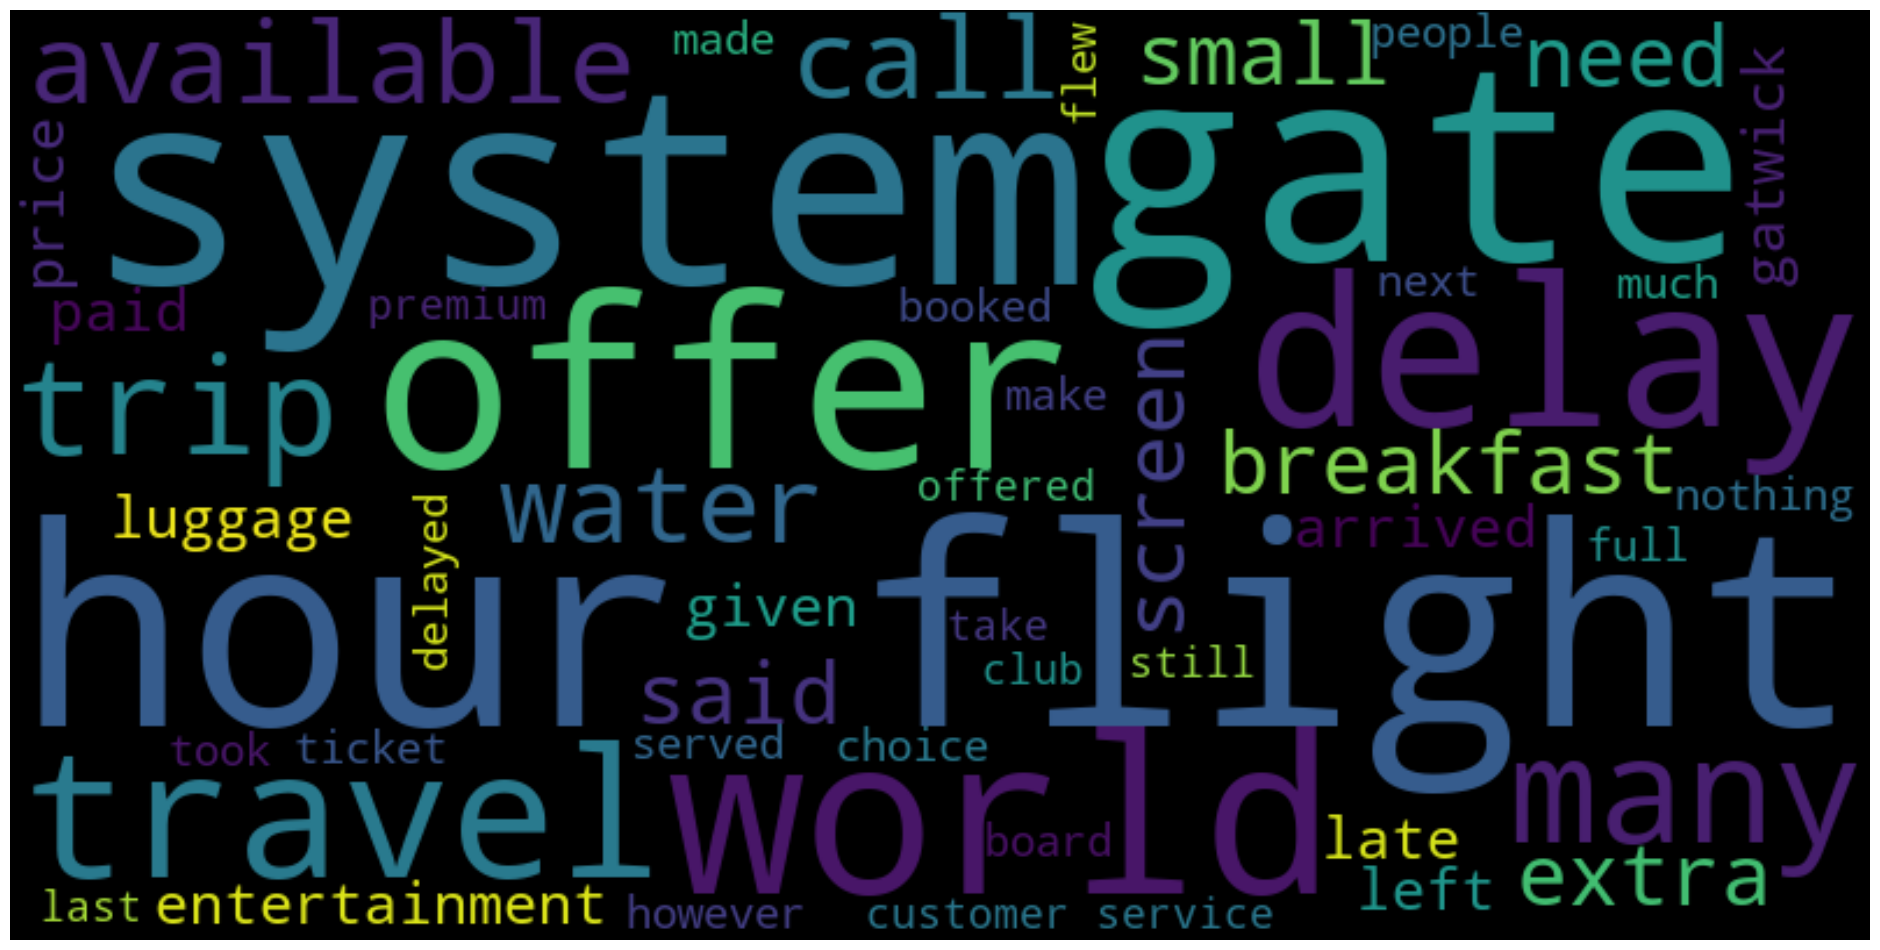

In [ ]:
wc = WordCloud(width=800, height=400, max_words=10).generate_from_frequencies(Counter(df_idf['idf_weights'].to_dict()))
plt.figure(figsize=(24,20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()